##### 1. Read and explore the given dataset. ( Rename column/add headers, plot
##### histograms, find data characteristics) ( 3 Marks)
##### 2. Build Popularity Recommender model. ( 10 marks)
#####  3. Split the data randomly into a train and test dataset. ( For example, split it in
##### 70/30 ratio) ( 2 marks)
##### 4. Build Collaborative Filtering model. ( 10 marks)
#####  5. Evaluate the above model. ( Once the model is trained on the training data, it
#####  can be used to compute the error (like RMSE) on predictions made on the test
#####  data.) You can also use a different method to evaluate the models. ( 5 marks)
##### 6. Get top - K ( K = 5) recommendations. Since our goal is to recommend new
#####  products to each user based on his/her habits, we will recommend 5 new
##### products. ( 10 marks)
##### 7. Summarise your insights. ( 10 marks)

#### Importing libraries

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

##### Reading ,changing columns name and exploring Data along with histograms or countplots

In [2]:
df = pd.read_csv('Electronic_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    500000 non-null  object 
 1   prod_id    500000 non-null  object 
 2   ratings    500000 non-null  float64
 3   timestamp  500000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


In [4]:
df.head()

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


In [5]:
df.shape

(500000, 4)

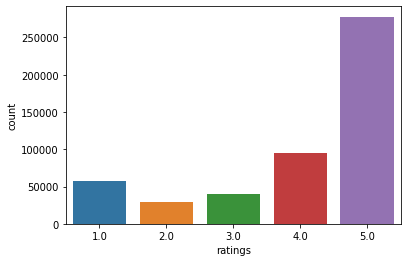

In [6]:
sns.countplot(df['ratings'])

In [7]:
df.isnull().any().sum()

0

In [8]:
user_counts=df['user_id'].value_counts()

In [9]:
user_counts

A680RUE1FDO8B     36
A3OXHLG6DIBRW8    34
ADLVFFE4VBT8      30
A5JLAU2ARJ0BO     29
A2NOW4U7W3F7RI    28
                  ..
A9TQ8FBRNQDBH      1
A1417SB1XZSYDH     1
A3CKST1Q8O0O9Z     1
A3KGBRH8Z94AA0     1
AADHDMFHH5JWY      1
Name: user_id, Length: 448368, dtype: int64

In [10]:
df.drop('timestamp',axis=1,inplace=True)

In [11]:
df.dtypes

user_id     object
prod_id     object
ratings    float64
dtype: object

In [12]:
df['ratings'].describe()

count    500000.000000
mean          4.013172
std           1.379996
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: ratings, dtype: float64

In [13]:
df['user_id'].nunique()

448368

In [14]:
df['prod_id'].nunique()

130138

In [15]:
# Top 10 users with most ratings

top_10 = df.groupby('user_id').size().sort_values(ascending=False)[0:10]

In [16]:
counts=df.user_id.value_counts()
df_datatrim=df[df.user_id.isin(counts[counts>=15].index)]

In [17]:
print('Number of users who have rated 15 or more items =', len(df_datatrim))
print('Number of unique users  = ', df_datatrim['user_id'].nunique())
print('Number of unique products  = ', df_datatrim['prod_id'].nunique())

Number of users who have rated 15 or more items = 757
Number of unique users  =  39
Number of unique products  =  725


In [18]:
df_datatrim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 757 entries, 413 to 499916
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  757 non-null    object 
 1   prod_id  757 non-null    object 
 2   ratings  757 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.7+ KB


#####  Popularity based Recommendation model

In [19]:
# Lets device a score column i.e. Count of user_id for each unique product 
df_datatrim_grp = df_datatrim.groupby('prod_id').agg({'user_id': 'count'}).reset_index()
df_datatrim_grp.rename(columns = {'user_id': 'score'},inplace=True)

In [20]:
#Sort the products on recommendation score 
final_pop = df_datatrim_grp.sort_values(['score', 'prod_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
final_pop['rank'] = final_pop['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
pop_reco = final_pop.head(5) 
pop_reco

,prod_id,score,rank
67,B0000AAAPF,3,1.0
341,B003ES5ZSW,3,2.0
414,B004T9RR6I,3,3.0
513,B007WTAJTO,3,4.0
691,B00HHRP11C,3,5.0


#### Splitting  the data randomly into train and test dataset.

In [21]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(df_datatrim, test_size = 0.3, random_state=0)
train_data.head()

,user_id,prod_id,ratings
444282,A5JLAU2ARJ0BO,B000083K9F,5.0
216624,A3T7V207KRDE2O,B001G9WAF2,5.0
130269,A1ODOGXEYECQQ8,B00JGGUBPI,4.0
219081,A231WM2Z2JL0U3,B00006SG3W,5.0
368225,A2AY4YUOX2N1BQ,B003TO51LC,4.0


#### User Based Collaborative Filtering model

In [22]:
# Transforming  data to surprise format
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor


reader = Reader(rating_scale=(1, 5))

In [23]:
temp=df_datatrim.groupby('user_id').agg({'prod_id':'count'}).reset_index()
user_l=temp[temp['prod_id']>=10]['user_id'].unique()
df_datatrim_new=df_datatrim[df_datatrim['user_id'].isin(user_l)]

In [24]:
df_datatrim.head()


,user_id,prod_id,ratings
413,A10Y058K7B96C6,B005HSG3VK,5.0
983,A680RUE1FDO8B,B004URTJ6U,4.0
2726,A6FIAB28IS79,B004J3ZV62,5.0
2740,A6FIAB28IS79,B0012UKOV2,5.0
2808,A2NYK9KWFMJV4Y,B00ISFNSBW,5.0


In [25]:
new_data = Dataset.load_from_df(df_datatrim, reader)

In [26]:
new_data.df.head()

,user_id,prod_id,ratings
413,A10Y058K7B96C6,B005HSG3VK,5.0
983,A680RUE1FDO8B,B004URTJ6U,4.0
2726,A6FIAB28IS79,B004J3ZV62,5.0
2740,A6FIAB28IS79,B0012UKOV2,5.0
2808,A2NYK9KWFMJV4Y,B00ISFNSBW,5.0


In [27]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(new_data, test_size = .3)

In [28]:
from surprise import SVD
algo = SVD()
algo.fit(trainset)

In [29]:
test_prediction = algo.test(testset)

In [30]:
test_prediction

[Prediction(uid='A4WEZJOIZIV4U', iid='B00DDK1QUC', r_ui=4.0, est=4.191474383463822, details={'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid='B009F1I1C4', r_ui=4.0, est=4.273220500540541, details={'was_impossible': False}),
 Prediction(uid='A3OA4DV4L81N1D', iid='B0014E9A2K', r_ui=5.0, est=4.36444986253731, details={'was_impossible': False}),
 Prediction(uid='A3LGT6UZL99IW1', iid='B001EYTPO8', r_ui=2.0, est=4.303926170761923, details={'was_impossible': False}),
 Prediction(uid='A3T7V207KRDE2O', iid='B0081FLFQE', r_ui=5.0, est=4.409120275608143, details={'was_impossible': False}),
 Prediction(uid='A680RUE1FDO8B', iid='B001BWLA8W', r_ui=5.0, est=4.4336302967511285, details={'was_impossible': False}),
 Prediction(uid='A1F9Z42CFF9IAY', iid='B0033A7JG2', r_ui=5.0, est=3.942725084909474, details={'was_impossible': False}),
 Prediction(uid='A23GFTVIETX7DS', iid='B000W6O08A', r_ui=5.0, est=4.397760613237492, details={'was_impossible': False}),
 Prediction(uid='A3A4ZAIBQWKOZS', i

In [31]:
from surprise import accuracy

In [32]:
accuracy.rmse(test_prediction)

RMSE: 0.9273


0.9273454490114382

#####  Top - K ( K = 5) recommendations. Recommending 5 new products

In [33]:
from collections import defaultdict
def get_top_n(predictions, userid,  n=5):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if uid == userid:
            top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [34]:
top_n = get_top_n(test_prediction, userid = 'A2NOW4U7W3F7RI'  , n=5)

In [35]:
top_n

defaultdict(list,
            {'A2NOW4U7W3F7RI': [('B00HHRP11C', 4.6848212492485475),
              ('B00I0Z427E', 4.511973504835925),
              ('B001F7AJKI', 4.511973504835925),
              ('B00FLKW0JI', 4.511973504835925),
              ('B0040QE998', 4.511973504835925)]})

##### We have successfully recommended top 10 prediction on the basis of popularity. In collabrotive modelling we predicted the estimated ratings and we calulate the RMSE On these prediction.There after we recommended the top five product to all similar users athe basis of predictive ratings. 


###### As per the recorded RMSE value, we can say user based filtering is a better option.
##### Lack of personalization makes the popularity based recommendation model less relevant as compared to user based one.


